# Extratropical Temperature Quantile Theory
This notebook looks at trying to recreate the black lines of Figure 2 of Byrne 2021. I.e. it tries to estimate the temperature above a given quantile, given details of the average summer day of that climate in the extratropics.

It looks at the difference between the $\kappa=2$ and $\kappa=1$ simulations because both of these simulations are convectively neutral on the hottest and average summer days in the extratropics.



In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-01-26 17:50:14,907 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
tau_lw_ref = 1
tau_lw_warm = 2
exp_names = [f'k={tau_lw_ref}', f'k={tau_lw_warm}']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset, `ds_quant`, for extratropics averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer.

In [4]:
# Get data set averaged over all summer days in extratropics.
# Do this for each optical depth value
use_time_start = 360*2
region = 'Extratropics'
lat_min = 30
lat_max = 60

temp_summer_av = np.zeros(n_exp)
ds_summer = []
for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
    ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
    # Combine hemispheres and average over longitude, time and latitude.
    ds_use = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
    ds_summer += [ds_use]
    ds_summer[i].load()     # Load in averaged dataset so later computation and conversion to numpy is much quicker
    temp_summer_av[i] = ds_summer[i].temp[-1]

100%|██████████| 2/2 [00:25<00:00, 12.69s/it]


In [5]:
# Get data set averaged over all days exceeding every quantile of near surface temperature in extratropics.
# Do this for each optical depth value and each quantile
quantiles_all = np.arange(90, 100)
n_quantiles = len(quantiles_all)
temp_local_mean = np.zeros(n_exp)
temp_all_quant = np.zeros((n_exp, n_quantiles))
sphum_all_quant = np.zeros((n_exp, n_quantiles))
ds_quant = [[], []]
for i in range(n_exp):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)    # Only latitude region
    # Collapse to single coordinate and then take quantile over it
    ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    temp_local_mean[i] = ds_use.temp[-1].mean(dim='lon_lat_time').to_numpy()
    for j in tqdm(range(n_quantiles)):
        quantile_thresh = ds_use.temp[-1].quantile(quantiles_all[j]/100, dim='lon_lat_time', keep_attrs=True)
        # Average each variable in data over days where near surface temperature exceeds this quantile
        ds_use2 = ds_use.where(ds_use.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
        ds_quant[i] += [ds_use2]
        ds_quant[i][j].load()  # Load in averaged dataset so later computation and conversion to numpy is much quicker

        # Record mean extratropical near surface temperature
        temp_all_quant[i, j] = ds_quant[i][j].temp[-1]

100%|██████████| 10/10 [04:12<00:00, 25.28s/it]


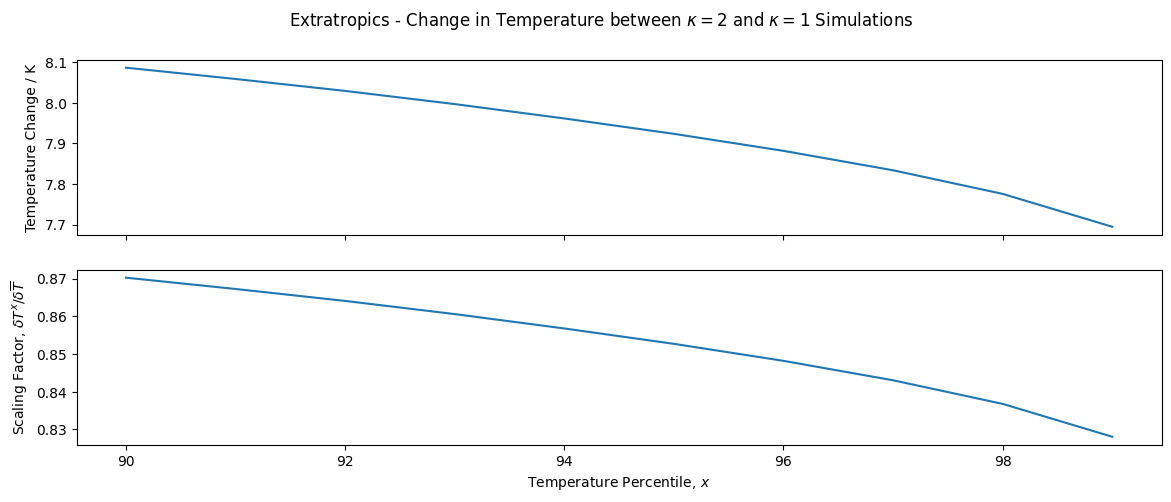

In [6]:
# In second plot here, normalise by change in the summer mean temperature
temp_diff_quant = temp_all_quant[1]-temp_all_quant[0]
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant)
ax[0].set_ylabel('Temperature Change / K')
ax[1].plot(quantiles_all, temp_diff_quant/(temp_summer_av[1] - temp_summer_av[0]))
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Theory for Temperature Change, $\delta T_x$ of days exceeding percentile $x$
This is trying to get a theory for the change in temperature of a given percentile day in a manor analagous to byrne 2021.

In [7]:
p_surface = float(ds_summer[0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_surface_sat(temp):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), p_surface)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

# Get the average temperature between experiments for computing some of the parameters below
# Initially thought should use the mid point for this but actually in taylor series, you evaluate at lowest (k=1) value.,
# temp_mean_mid = np.mean(temp_summer_av)             # mean refers to summer mean
temp_mean_mid = temp_summer_av[0]
# temp_quant_mid = np.mean(temp_all_quant, axis=0)
temp_quant_mid = temp_all_quant[0]

In [77]:
# Compute constants required for theory
alpha_quant = clausius_clapeyron_factor(temp_quant_mid)
alpha_mean = clausius_clapeyron_factor(temp_mean_mid)
q_quant = np.asarray([np.asarray([ds_quant[i][j].sphum[-1] for j in range(n_quantiles)]) for i in range(n_exp)])
# q_quant_mid = np.mean(q_quant, axis=0)
q_quant_mid = q_quant[0]
q_mean = np.asarray([ds_summer[i].sphum[-1] for i in range(n_exp)])
# q_mean_mid = np.mean(q_mean)
q_mean_mid = q_mean[0]
rh_quant = rh_from_sphum(q_quant,temp_all_quant,p_surface)/100
rh_mean = rh_from_sphum(q_mean,temp_summer_av,p_surface)/100

q_sat_quant = sphum_surface_sat(temp_quant_mid)
q_sat_mean = sphum_surface_sat(temp_mean_mid)

epsilon_constant = (L_v * alpha_quant * q_sat_quant) / (c_p + L_v * alpha_quant * q_quant_mid)
delta_rh_quant = rh_quant[1] - rh_quant[0]
delta_t_mean = temp_summer_av[1] - temp_summer_av[0]
delta_rh_mean = rh_mean[1] - rh_mean[0]

# Change 1 to 0 to leave out the drdT terms below, but they are important I think
denom = c_p + L_v * alpha_quant * (q_quant_mid + 1 * q_sat_quant * delta_rh_quant)
gamma_t = (c_p + L_v * alpha_mean * (q_mean_mid + 1 * q_sat_mean * delta_rh_mean))/denom
gamma_t_zero_rh = (c_p + L_v * alpha_mean * q_mean_mid)/(c_p + L_v * alpha_quant * q_quant_mid)
gamma_r = L_v * q_sat_mean / denom
gamma_r_quant = -L_v * q_sat_quant / denom
gamma_mse = 1 / denom

In [9]:
# Compute the delta h* term based on the saturation MSE in the free troposphere
pressure_ft = 700
def mse_ft(dataset):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    ds_use = dataset.sel(pfull=pressure_ft, method='nearest')
    pressure_ft_actual = ds_use.pfull * 100     # This is the pressure level closest to pressure_ft
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), pressure_ft_actual)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)

mse_quant = np.zeros((n_exp, n_quantiles))
mse_ft_sat_quant = np.zeros((n_exp, n_quantiles))
mse_summer = np.zeros(n_exp)
mse_ft_sat_summer = np.zeros(n_exp)
for i in range(n_exp):
    mse_summer[i] = moist_static_energy(ds_summer[i].temp[-1], ds_summer[i].sphum[-1], ds_summer[i].height[-1])
    mse_ft_sat_summer[i] = mse_ft(ds_summer[i])
    for j in range(n_quantiles):
        mse_quant[i, j] = moist_static_energy(ds_quant[i][j].temp[-1], ds_quant[i][j].sphum[-1], ds_quant[i][j].height[-1])
        mse_ft_sat_quant[i, j] = mse_ft(ds_quant[i][j])

mse_sat_diff = mse_ft_sat_quant - mse_ft_sat_summer.reshape(-1, 1)
delta_mse_sat_diff = (mse_sat_diff[1] - mse_sat_diff[0]) * 1000   # *1000 so in units of J/kg

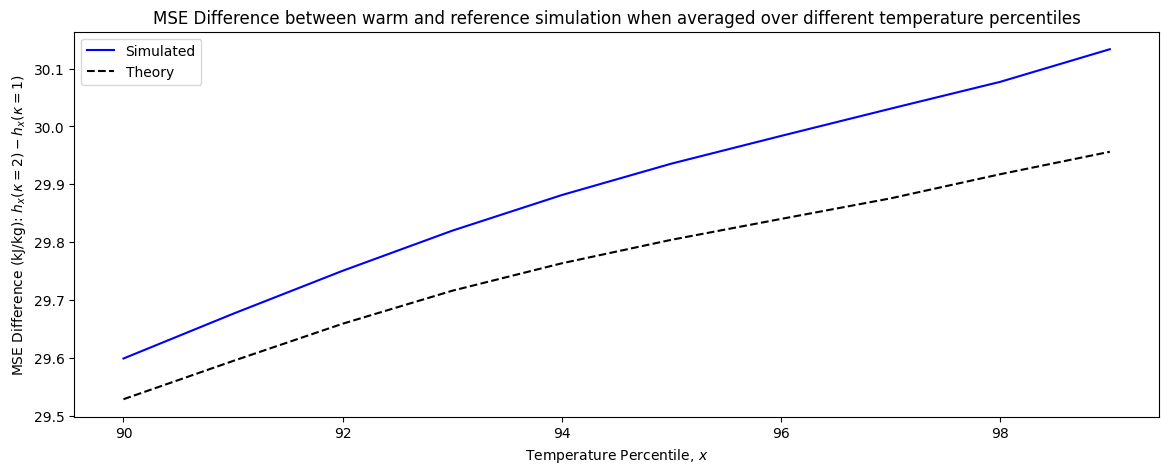

In [10]:
## Compare predicted MSE difference to that from the theory
mse_quant_diff = (c_p * temp_diff_quant + L_v * (q_quant[1]-q_quant[0])) / 1000
mse_quant_diff_sim = (c_p * (temp_summer_av[1]-temp_summer_av[0]) + L_v * (q_mean[1]-q_mean[0]))/1000 + mse_sat_diff[1]-mse_sat_diff[0]

fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(quantiles_all, mse_quant_diff, color='blue', label='Simulated')
ax.plot(quantiles_all, mse_quant_diff_sim, color='k', linestyle='--', label='Theory')
ax.set_xlabel('Temperature Percentile, $x$')
ax.set_ylabel(f'MSE Difference (kJ/kg): $h_x(\kappa={tau_lw_warm})-h_x(\kappa={tau_lw_ref})$')
ax.set_title('MSE Difference between warm and reference simulation when averaged over different temperature percentiles')
ax.legend();

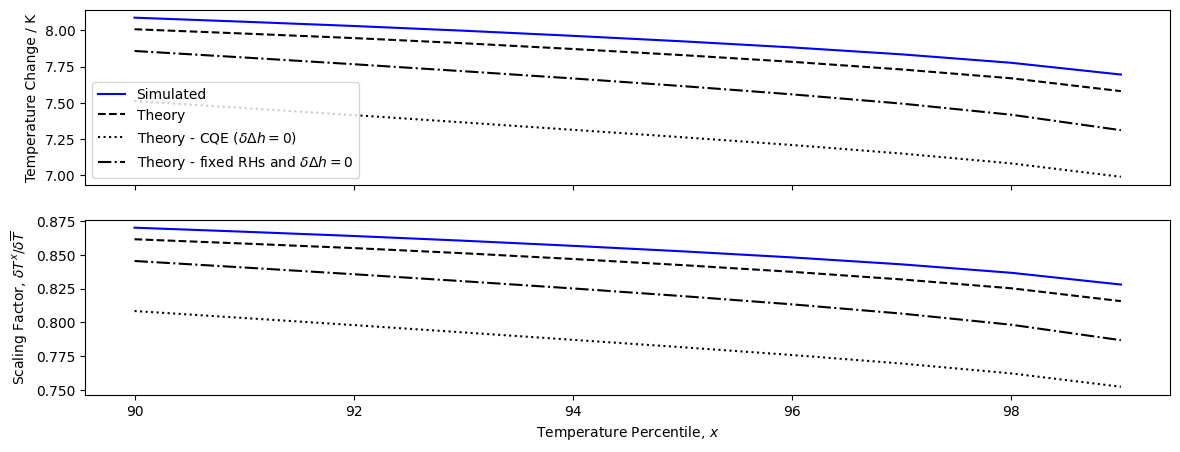

In [80]:
# Compared predicted temperature difference - Figure 2 of byrne 2021
temp_diff_theory = gamma_t*delta_t_mean + gamma_r * delta_rh_mean + gamma_r_quant * delta_rh_quant + \
                   gamma_mse * delta_mse_sat_diff
temp_diff_theory_cqe = gamma_t*delta_t_mean + gamma_r * delta_rh_mean + gamma_r_quant * delta_rh_quant
temp_diff_theory_const_rh = gamma_t_zero_rh*delta_t_mean
# Consider adding non-linear term to theory temperature
# temp_diff_theory = temp_diff_theory + prefactor * gamma_nl * delta_rh_mean * delta_t_mean
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant, color='blue', label='Simulated')
ax[0].plot(quantiles_all, temp_diff_theory, color='k', linestyle='--', label='Theory')
ax[0].plot(quantiles_all, temp_diff_theory_cqe, color='k', linestyle=':', label='Theory - CQE ($\delta \Delta h = 0$)')
ax[0].plot(quantiles_all, temp_diff_theory_const_rh, color='k', linestyle='-.', label='Theory - fixed RHs and $\delta \Delta h = 0$')
ax[1].plot(quantiles_all, temp_diff_quant/(temp_summer_av[1] - temp_summer_av[0]), color='blue', label='Simulated')
ax[1].plot(quantiles_all, temp_diff_theory/(temp_summer_av[1] - temp_summer_av[0]), color='k', linestyle='--', label='Theory')
ax[1].plot(quantiles_all, temp_diff_theory_cqe/ (temp_summer_av[1] - temp_summer_av[0]),
           color='k', linestyle=':', label='Theory - CQE ($\delta \Delta h = 0$)')
ax[1].plot(quantiles_all, temp_diff_theory_const_rh / (temp_summer_av[1] - temp_summer_av[0]),
           color='k', linestyle='-.', label='Theory - fixed RHs and $\Delta h = 0$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();

## Breakdown the contributions to the theoretical temperature change
The idea here is to breakdown the temperature contributions to see what is the dominant term in the theory, explaining why the temperature change decreases as the percentile increases.

It is basically replicating Figure 4 of Byrne 2021.

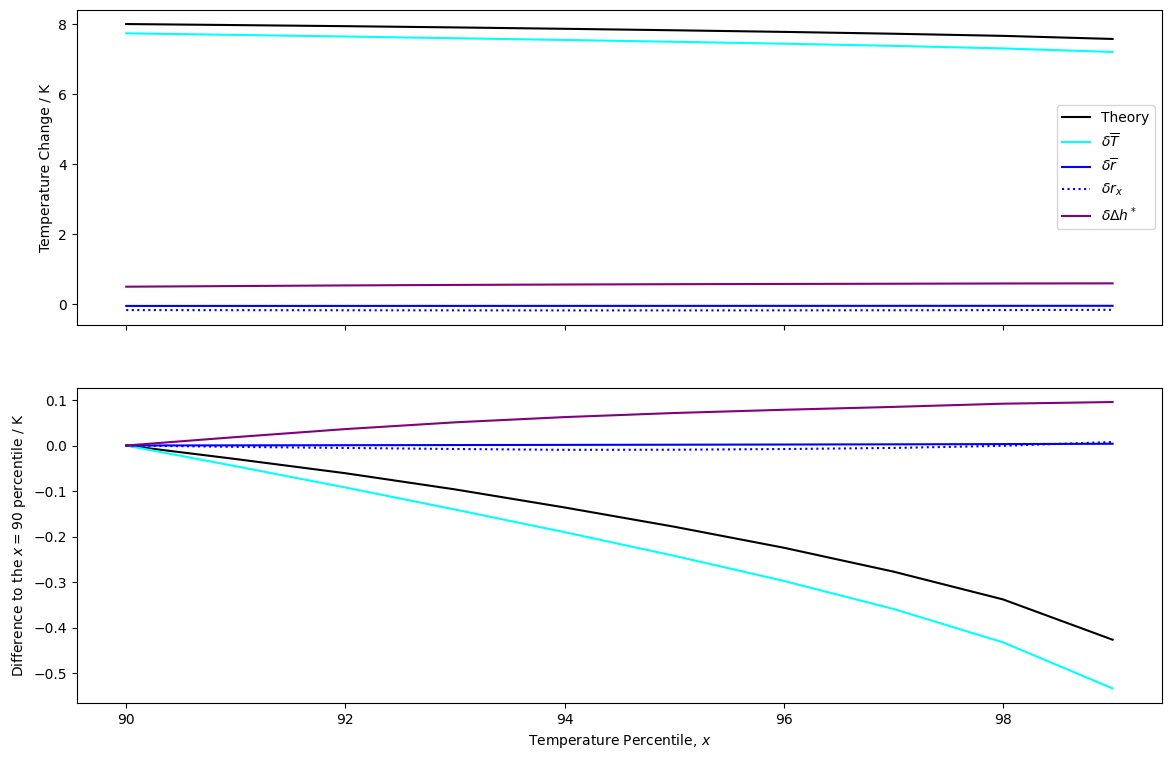

In [12]:
temp_diff_terms = [gamma_t * delta_t_mean, gamma_r * delta_rh_mean, gamma_r_quant * delta_rh_quant, gamma_mse * delta_mse_sat_diff]
temp_diff_terms = [term for term in temp_diff_terms]
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
ax[0].plot(quantiles_all, temp_diff_theory, color='k', label='Theory')
ax[0].plot(quantiles_all, temp_diff_terms[0], color='cyan', label='$\delta \overline{T}$')
ax[0].plot(quantiles_all, temp_diff_terms[1], color='blue', label='$\delta \overline{r}$')
ax[0].plot(quantiles_all, temp_diff_terms[2], color='blue', label='$\delta r_x$', linestyle=':')
ax[0].plot(quantiles_all, temp_diff_terms[3], color='purple', label='$\delta \Delta h^*$')

ax[1].plot(quantiles_all, temp_diff_theory - temp_diff_theory[0], color='k', label='Theory')
ax[1].plot(quantiles_all, temp_diff_terms[0]-temp_diff_terms[0][0], color='cyan', label='$\delta \overline{T}$')
ax[1].plot(quantiles_all, temp_diff_terms[1]-temp_diff_terms[1][0], color='blue', label='$\delta \overline{r}$')
ax[1].plot(quantiles_all, temp_diff_terms[2]-temp_diff_terms[2][0], color='blue', label='$\delta r_x$', linestyle=':')
ax[1].plot(quantiles_all, temp_diff_terms[3]-temp_diff_terms[3][0], color='purple', label='$\delta \Delta h^*$')

ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile / K')
ax[0].legend();

So from the above plots, the fact that the mean temperature contribution $\delta \overline{T}$ is the dominant effect. The relative humidities don't really do anything and the moist static energy increases as temperature percentile increases, but this increase is dominated by the $\delta \overline{T}$ effect.

To investigate this further, I plot how the sensitivities ($\gamma$ factors) vary with percentile, in plots analagous to Extended data Figure 4 of Byrne 2021:

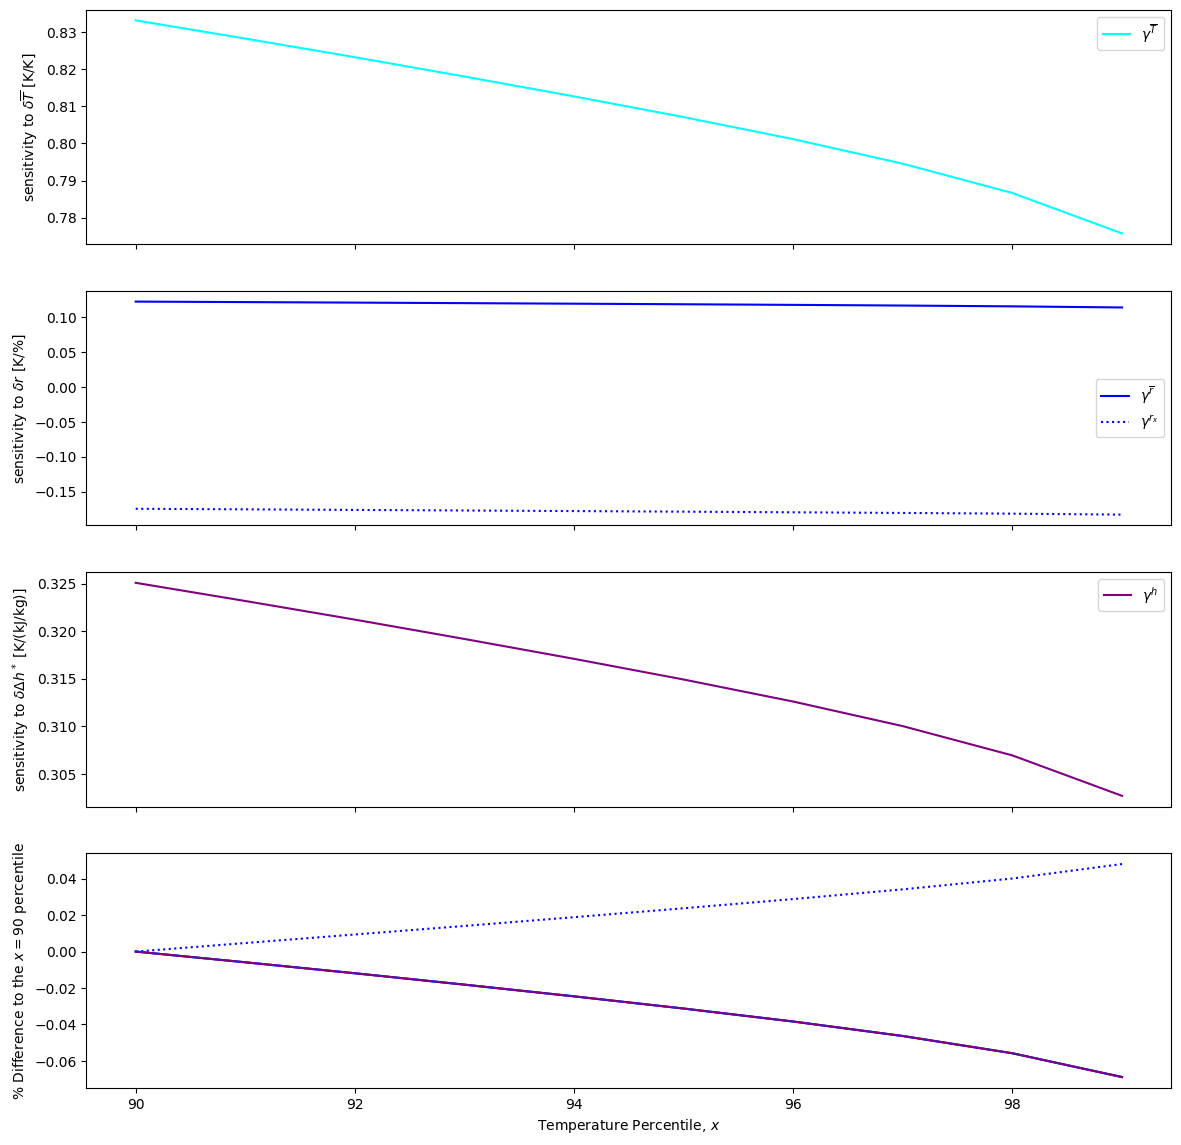

In [13]:
fig, ax = plt.subplots(4,1, figsize=(14, 14), sharex=True)
ax[0].plot(quantiles_all, gamma_t, color='cyan', label='$\gamma^{\overline{T}}$')
ax[0].set_ylabel('sensitivity to $\delta \overline{T}$ [K/K]')
ax[0].legend()

ax[1].plot(quantiles_all, gamma_r/100, color='blue', label='$\gamma^{\overline{r}}$')
ax[1].plot(quantiles_all, gamma_r_quant/100, color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[1].set_ylabel('sensitivity to $\delta r$ [K/%]')
ax[1].legend()

ax[2].plot(quantiles_all, gamma_mse * 1000, color='purple', label='$\gamma^{h}$')
ax[2].set_ylabel('sensitivity to $\delta \Delta h^*$ [K/(kJ/kg)]')
ax[2].legend()

ax[3].plot(quantiles_all, (gamma_t-gamma_t[0])/gamma_t[0], color='cyan', label='$\gamma^{\overline{T}}$')
ax[3].plot(quantiles_all, (gamma_r-gamma_r[0])/gamma_r[0], color='blue', label='$\gamma^{\overline{r}}$')
ax[3].plot(quantiles_all, (gamma_r_quant-gamma_r_quant[0])/gamma_r_quant[0], color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[3].plot(quantiles_all, (gamma_mse-gamma_mse[0])/gamma_mse[0], color='purple', label='$\gamma^{h}$')
ax[3].set_ylabel(f'% Difference to the $x={quantiles_all[0]}$ percentile')
ax[3].set_xlabel('Temperature Percentile, $x$');

From this, wee see that the sensitivity to the mean summer temperature (first plot) shows the opposite behaviour here to that in byrne 2021, where the sensitivity increases with percentile.

The sensitivity to relative humidity on hot days (orange) here behaves approximately the same way as sensitivity to land relative humidity in byrne 2021. But here, the sensitivity to relative humidity on the average summer day (blue line) decreases whereas the analagous parameter in byrne 2021 increases with $x$.

We also see that the sensitivity to the moist static energy difference decreases with $x$.

## Decomposition of $\delta \Delta h^*$ term
This term depends on the average summer free troposphere temperature, the temperature difference and the geopotential height difference.


In [14]:
# Get free troposphere temperature and geopotential height
temp_ft_quant = np.zeros((n_exp, n_quantiles))
temp_ft_summer = np.zeros(n_exp)
z_quant = np.zeros((n_exp, n_quantiles))
z_ft_quant = np.zeros((n_exp, n_quantiles))
z_summer = np.zeros(n_exp)
z_ft_summer = np.zeros(n_exp)
for i in range(n_exp):
    z_summer[i] = ds_summer[i].height[-1]
    ds_use = ds_summer[i].sel(pfull=pressure_ft, method='nearest')
    temp_ft_summer[i] = float(ds_use.temp)
    z_ft_summer[i] = float(ds_use.height)
    for j in range(n_quantiles):
        z_quant[i, j] = ds_quant[i][j].height[-1]
        ds_use = ds_quant[i][j].sel(pfull=pressure_ft, method='nearest')
        temp_ft_quant[i, j] = float(ds_use.temp)
        z_ft_quant[i, j] = float(ds_use.height)
pressure_ft_actual = float(ds_use.pfull * 100)     # This is the pressure level closest to pressure_ft - same for all ds
temp_ft_diff = temp_ft_quant - temp_ft_summer.reshape(-1, 1)
z_ft_diff = z_ft_quant - z_ft_summer.reshape(-1, 1)
delta_temp_ft_mean = temp_ft_summer[1] - temp_ft_summer[0]
delta_temp_ft_quant = temp_ft_quant[1] - temp_ft_quant[0]
delta_temp_ft_diff = temp_ft_diff[1] - temp_ft_diff[0]
delta_z_ft_diff = z_ft_diff[1] - z_ft_diff[0]

In [15]:
# Decompose contributions to changes in /Delta h^*
def sphum_ft_sat(temp):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure_ft_actual)
    q_sat = w_sat / (1+w_sat)
    return q_sat

temp_ft_mean_mid = np.average(temp_ft_summer)
temp_ft_quant_mid = np.mean(temp_ft_quant, axis=0)
temp_ft_mean_mid = temp_ft_summer[0]
temp_ft_quant_mid = temp_ft_quant[0]
alpha_ft_mean = clausius_clapeyron_factor(temp_ft_mean_mid)
q_sat_ft_mean = sphum_ft_sat(temp_ft_mean_mid)
alpha_ft_quant = clausius_clapeyron_factor(temp_ft_quant_mid)
q_sat_ft_quant = sphum_ft_sat(temp_ft_quant_mid)

gamma_temp_ft_quant = c_p + L_v * alpha_ft_quant * q_sat_ft_quant
gamma_temp_ft_mean = -c_p - L_v * alpha_ft_mean * q_sat_ft_mean
gamma_z = g

delta_mse_sat_diff_sim = gamma_temp_ft_quant * delta_temp_ft_quant + gamma_temp_ft_mean * delta_temp_ft_mean + gamma_z * delta_z_ft_diff


In [16]:
# Compute coefficients in the taylor series version of the theory so in terms of temp_diff between mean and warmest days
# Underestimates difference
temp_ft_diff = temp_ft_quant - temp_ft_summer.reshape(-1,1)
temp_ft_diff_mid = temp_ft_diff[0]
gamma_temp_ft_mean2 = L_v * alpha_ft_mean * q_sat_ft_mean * \
                      (alpha_ft_mean * temp_ft_mean_mid - 2) * temp_ft_diff_mid / temp_ft_mean_mid
gamma_temp_ft_diff2 = c_p + L_v * alpha_ft_mean * q_sat_ft_mean
# If computed using the T^2 term in the q* expansion - overestimates
gamma_temp_ft_mean3 = gamma_temp_ft_mean2 + L_v * alpha_ft_mean * q_sat_ft_mean * (
    (alpha_ft_mean**2 * temp_ft_mean_mid**2 - 3 * alpha_ft_mean * temp_ft_mean_mid + 6)*0.5*temp_ft_diff_mid**2/temp_ft_mean_mid**2)
gamma_temp_ft_diff3 = gamma_temp_ft_diff2 + \
                      L_v * alpha_ft_mean * q_sat_ft_mean * (alpha_ft_mean * temp_ft_mean_mid - 2) * temp_ft_diff_mid/temp_ft_mean_mid
# gamma_ft_nl = L_v * alpha_ft_mean * q_sat_ft_mean * (
#         (alpha_ft_mean * temp_ft_mean_mid - 2) / temp_ft_mean_mid +
#         (alpha_ft_mean**2 * temp_ft_mean_mid**2 - 3 * alpha_ft_mean * temp_ft_mean_mid + 6)*temp_ft_diff_mid/temp_ft_mean_mid**2)
delta_mse_sat_diff_sim2 = gamma_temp_ft_mean2*delta_temp_ft_mean + gamma_temp_ft_diff2 * delta_temp_ft_diff + gamma_z * delta_z_ft_diff

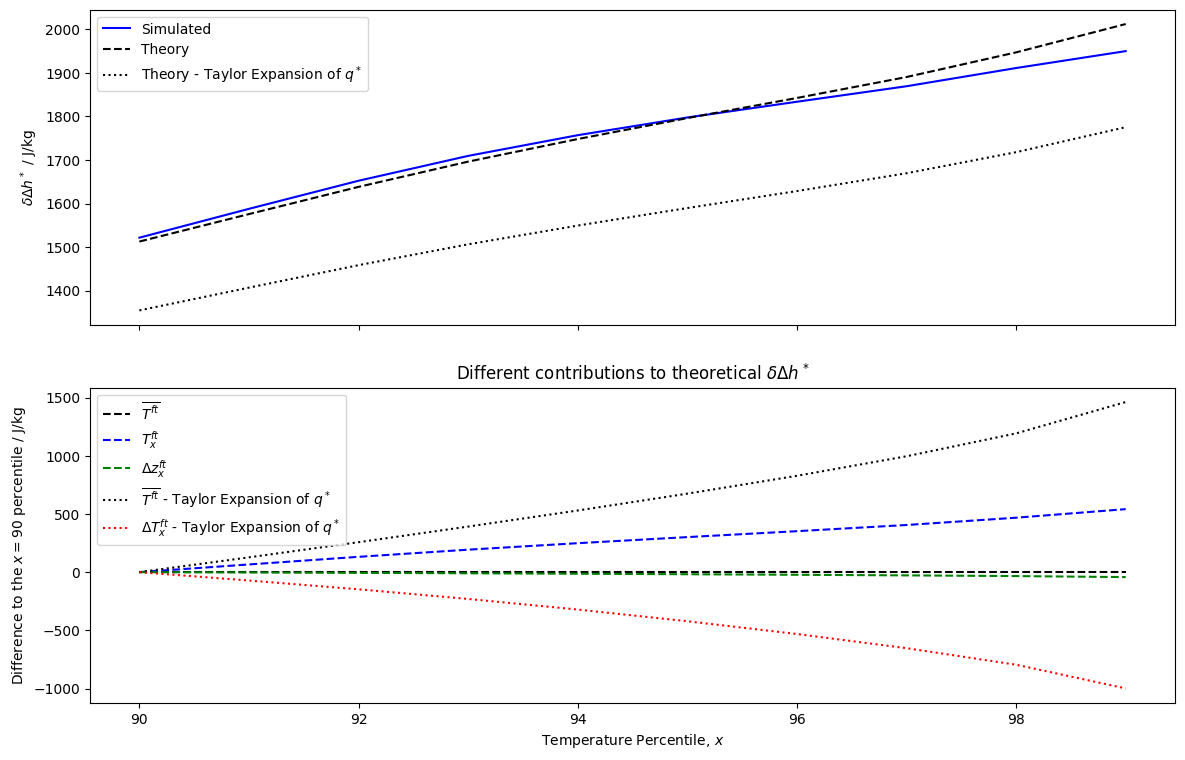

In [17]:
# Plot simulated vs theory delta h*, and then the contributions towards it
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
ax[0].plot(quantiles_all, delta_mse_sat_diff, color='blue', label='Simulated')
ax[0].plot(quantiles_all, delta_mse_sat_diff_sim, color='k', linestyle='--', label='Theory')
ax[0].plot(quantiles_all, delta_mse_sat_diff_sim2, color='k', linestyle=':', label='Theory - Taylor Expansion of $q^*$')
ax[1].plot(quantiles_all, quantiles_all * 0, linestyle='--', label='$\overline{T^{ft}}}$', color='k')
ax[1].plot(quantiles_all, gamma_temp_ft_quant * delta_temp_ft_quant - (gamma_temp_ft_quant * delta_temp_ft_quant)[0],
           linestyle='--', color='blue', label='$T^{ft}_x$')
ax[1].plot(quantiles_all, gamma_z * delta_z_ft_diff - (gamma_z * delta_z_ft_diff)[0],
           linestyle='--', color='green', label='$\Delta z^{ft}_x$')
ax[1].plot(quantiles_all, gamma_temp_ft_mean2 * delta_temp_ft_mean - (gamma_temp_ft_mean2 * delta_temp_ft_mean)[0],
           linestyle=':', color='k', label='$\overline{T^{ft}}}$ - Taylor Expansion of $q^*$')
ax[1].plot(quantiles_all, gamma_temp_ft_diff2 * delta_temp_ft_diff - (gamma_temp_ft_diff2 * delta_temp_ft_diff)[0],
           linestyle=':', color='red', label='$\Delta T^{ft}_x$ - Taylor Expansion of $q^*$')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$\delta\Delta h^*$ / J/kg')
ax[1].set_title('Different contributions to theoretical $\delta\Delta h^*$')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile / J/kg')
ax[1].set_xlabel('Temperature Percentile, $x$');

From this, it seems that the change in geopotential height of the free troposphere has very little effect and the major effect is because the temperature of the free troposphere increases as we move to higher percentiles (blue line).

From the taylor expansion lines, we see that the difference in free troposphere temperature and the mean temperature has a lesser effect as we move to high percentiles $x$. But this overwhealmed by the increasing effect that the increased temperature of the average summer day (black dotted line) has.

This is because the sensitivity to the mean summer temperature (`gamma_temp_ft_mean2`) increases as $x$ increases. I need to add another assumption to get a complete theory.

But $\delta \Delta h_x$ is clearly dependent on $\delta T_x$ and $\delta \overline{T}$ so I think this is somewhat a circular argument.

I think the systematic offset of the taylor expansion theory from the simulated value is because the temperature differences between the $x$ percentile and mean summer day are not small so you should go to higher order in the expansion.

## Theory 4: assuming $T_{x,ft} = \overline{T}_{ft} + \Delta T_{x, ft}$
Assume $\Delta T_{x, ft}$ is small so can taylor expand. Also, can relate $\overline{T}_{ft}$ to the surface temperature, $\overline{T}$, and relative humidity, $\overline{r}$ through assumption of convective equilibrium: $\overline{h} = \overline{h^*_{ft}}$. The logic behind this, is that in the tropics, the free troposphere temperature on the hot and mean day are the same so $\Delta T_{x, ft} = 0$ so can see the difference to the tropics more easily.

This then changes $\gamma^{\overline{T}}$ because it now includes a contribution that was in the $\delta \Delta h^*_x$ term.

In the plot below, it is clear that this theory overestimates the temperature change. This is probably because the assumption that $\Delta T_{x, ft}$ is small is not correct so a greater expansion in the taylor series of $q^*(T_{x,ft})$ was probably needed.

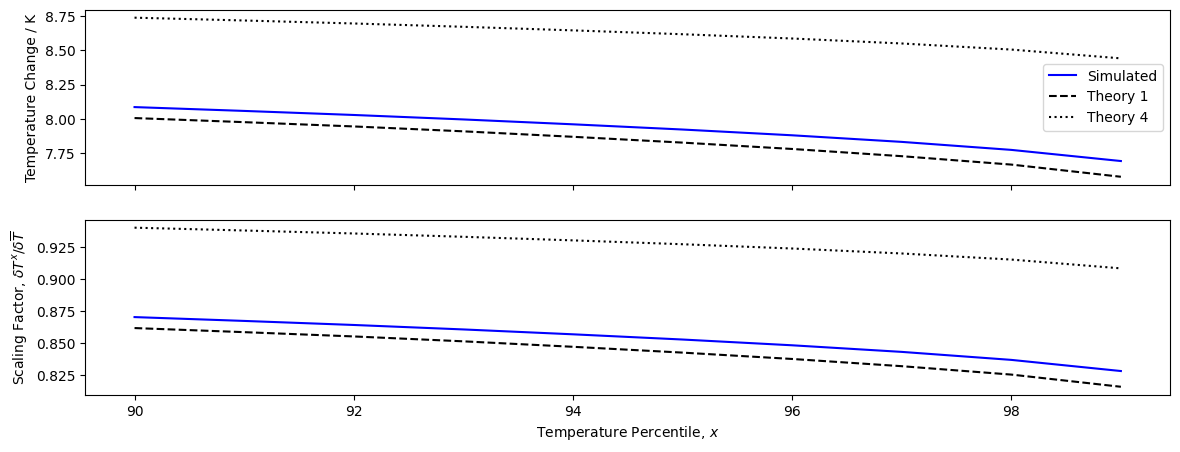

In [34]:
# Theory splitting the contribution from delta h* into temperature and geopotential terms

denom4 = c_p + L_v * q_quant_mid * alpha_quant
beta = (L_v * temp_ft_diff_mid * alpha_ft_mean * q_sat_ft_mean * (alpha_ft_mean - 2/temp_ft_mean_mid)) / \
       (c_p + L_v * alpha_ft_mean * q_sat_ft_mean)
gamma_t4 = ((c_p + L_v * alpha_mean * q_mean_mid) * (1+beta))/denom4
gamma_r4 = L_v * q_sat_mean * (1+beta) / denom4
gamma_r_quant4 = -L_v * q_quant_mid / denom4
gamma_temp_ft_diff4 = L_v * q_sat_ft_mean * alpha_ft_mean / denom4
gamma_z_quant4 = g / denom4
gamma_z4 = -g * (1+beta) / denom4

delta_z_ft_quant = z_ft_quant[1] - z_ft_quant[0]
delta_z_ft_mean = z_ft_summer[1] - z_ft_summer[0]

temp_diff_theory4 = gamma_t4*delta_t_mean + gamma_r4 * delta_rh_mean + gamma_r_quant4 * delta_rh_quant + \
                    gamma_temp_ft_diff4 * delta_temp_ft_diff + gamma_z_quant4 * delta_z_ft_quant + gamma_z4 * delta_z_ft_mean

fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant, color='blue', label='Simulated')
ax[0].plot(quantiles_all, temp_diff_theory, color='k', linestyle='--', label='Theory 1')
ax[0].plot(quantiles_all, temp_diff_theory4, color='k', linestyle=':', label='Theory 4')
ax[1].plot(quantiles_all, temp_diff_quant/(temp_summer_av[1] - temp_summer_av[0]), color='blue', label='Simulated')
ax[1].plot(quantiles_all, temp_diff_theory/(temp_summer_av[1] - temp_summer_av[0]), color='k', linestyle='--', label='Theory')
ax[1].plot(quantiles_all, temp_diff_theory4 / (temp_summer_av[1] - temp_summer_av[0]),
          color='k', linestyle=':', label='Theory - fixed RHs')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();

## Breakdown the contributions to the theoretical temperature change
The idea here is to breakdown the temperature contributions to see what is the dominant term in the theory, explaining why the temperature change decreases as the percentile increases.

It is basically replicating Figure 4 of Byrne 2021.

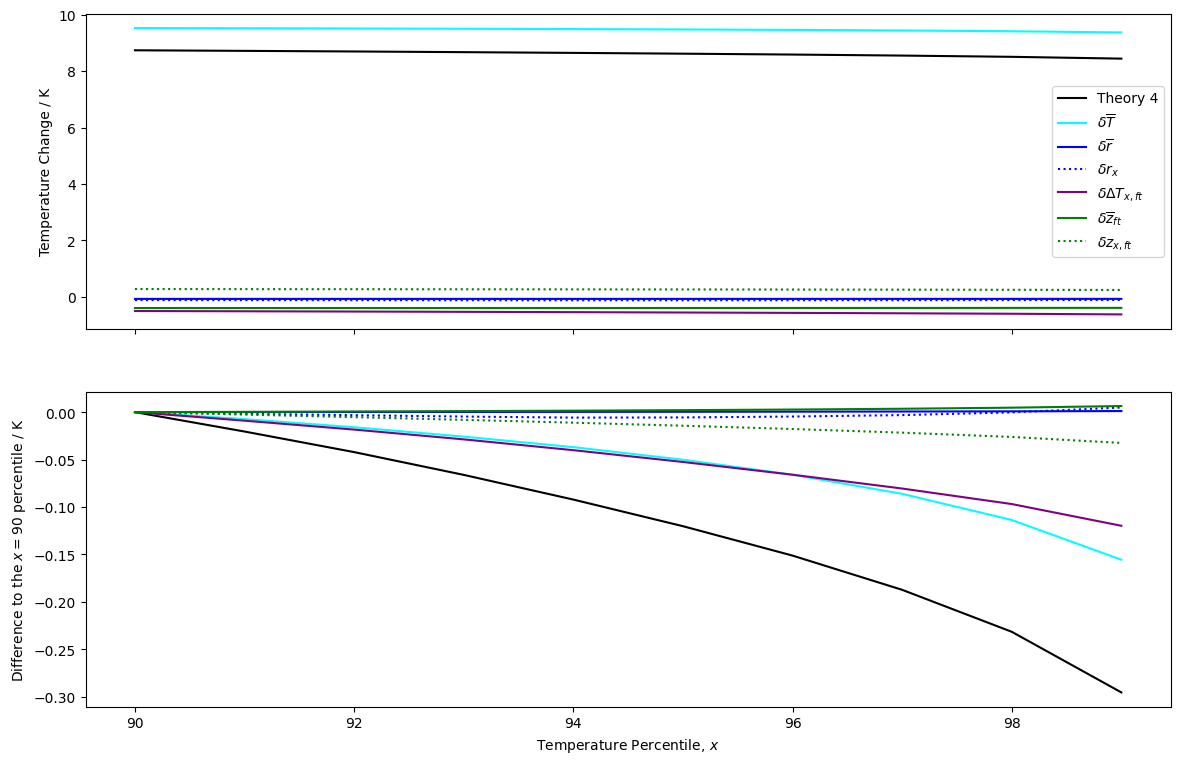

In [19]:
temp_diff_terms4 = [gamma_t4 * delta_t_mean, gamma_r4 * delta_rh_mean, gamma_r_quant4 * delta_rh_quant,
                   gamma_temp_ft_diff4 * delta_temp_ft_diff, gamma_z4 * delta_z_ft_mean, gamma_z_quant4 * delta_z_ft_quant]
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
ax[0].plot(quantiles_all, temp_diff_theory4, color='k', label='Theory 4')
ax[0].plot(quantiles_all, temp_diff_terms4[0], color='cyan', label='$\delta \overline{T}$')
ax[0].plot(quantiles_all, temp_diff_terms4[1], color='blue', label='$\delta \overline{r}$')
ax[0].plot(quantiles_all, temp_diff_terms4[2], color='blue', label='$\delta r_x$', linestyle=':')
ax[0].plot(quantiles_all, temp_diff_terms4[3], color='purple', label='$\delta \Delta T_{x,ft}$')
ax[0].plot(quantiles_all, temp_diff_terms4[4], color='green', label='$\delta \overline{z}_{ft}$')
ax[0].plot(quantiles_all, temp_diff_terms4[5], color='green', label='$\delta z_{x,ft}$', linestyle=':')

ax[1].plot(quantiles_all, temp_diff_theory4 - temp_diff_theory4[0], color='k', label='Theory 4')
ax[1].plot(quantiles_all, temp_diff_terms4[0]-temp_diff_terms4[0][0], color='cyan', label='$\delta \overline{T}$')
ax[1].plot(quantiles_all, temp_diff_terms4[1]-temp_diff_terms4[1][0], color='blue', label='$\delta \overline{r}$')
ax[1].plot(quantiles_all, temp_diff_terms4[2]-temp_diff_terms4[2][0], color='blue', label='$\delta r_x$', linestyle=':')
ax[1].plot(quantiles_all, temp_diff_terms4[3]-temp_diff_terms4[3][0], color='purple', label='$\delta \Delta h^*$')
ax[1].plot(quantiles_all, temp_diff_terms4[4]-temp_diff_terms4[4][0], color='green', label='$\delta \overline{z}_{ft}$')
ax[1].plot(quantiles_all, temp_diff_terms4[5]-temp_diff_terms4[5][0], color='green', label='$\delta z_{x,ft}$', linestyle=':')

ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile / K')
ax[0].legend();

The plots below show how the sensitivities ($\gamma$ factors) vary with percentile, in plots analagous to Extended data Figure 4 of Byrne 2021:

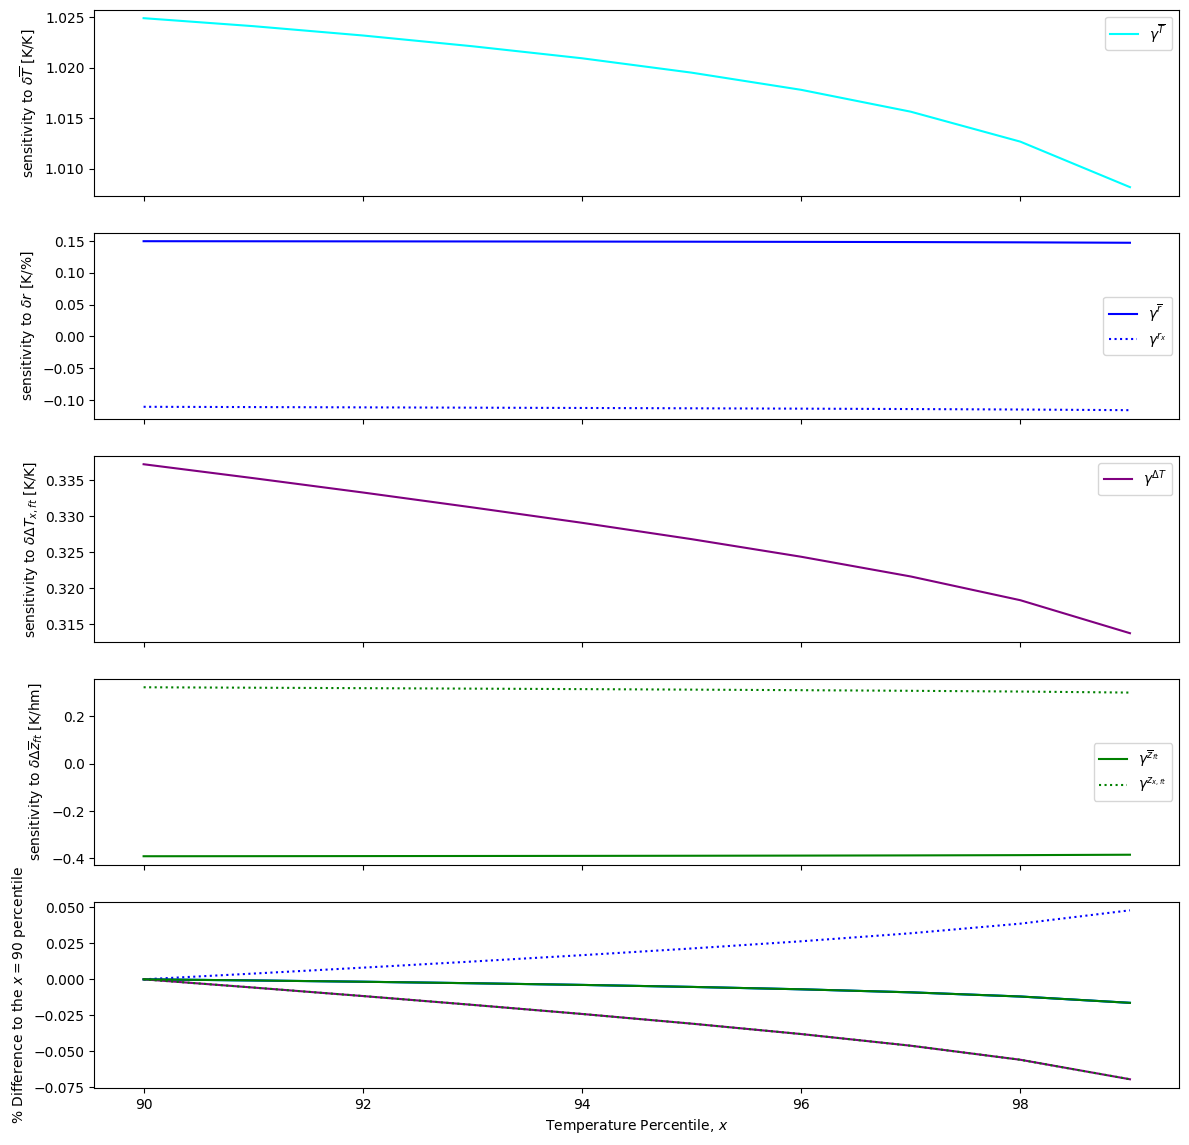

In [20]:
fig, ax = plt.subplots(5,1, figsize=(14, 14), sharex=True)
ax[0].plot(quantiles_all, gamma_t4, color='cyan', label='$\gamma^{\overline{T}}$')
ax[0].set_ylabel('sensitivity to $\delta \overline{T}$ [K/K]')
ax[0].legend()

ax[1].plot(quantiles_all, gamma_r4/100, color='blue', label='$\gamma^{\overline{r}}$')
ax[1].plot(quantiles_all, gamma_r_quant4/100, color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[1].set_ylabel('sensitivity to $\delta r$ [K/%]')
ax[1].legend()

ax[2].plot(quantiles_all, gamma_temp_ft_diff4, color='purple', label='$\gamma^{\Delta T}$')
ax[2].set_ylabel('sensitivity to $\delta \Delta T_{x,ft}$ [K/K]')
ax[2].legend()

ax[3].plot(quantiles_all, gamma_z4*100, color='green', label='$\gamma^{\overline{z}_{ft}}$')
ax[3].plot(quantiles_all, gamma_z_quant4*100, color='green', label='$\gamma^{z_{x, ft}}$', linestyle=':')
ax[3].set_ylabel('sensitivity to $\delta \Delta \overline{z}_{ft}}$ [K/hm]')
ax[3].legend()

ax[4].plot(quantiles_all, (gamma_t4-gamma_t4[0])/gamma_t4[0], color='cyan', label='$\gamma^{\overline{T}}$')
ax[4].plot(quantiles_all, (gamma_r4-gamma_r4[0])/gamma_r4[0], color='blue', label='$\gamma^{\overline{r}}$')
ax[4].plot(quantiles_all, (gamma_r_quant4-gamma_r_quant4[0])/gamma_r_quant4[0], color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[4].plot(quantiles_all, (gamma_temp_ft_diff4-gamma_temp_ft_diff4[0])/gamma_temp_ft_diff4[0], color='purple',
           label='$\gamma^{\Delta T}$')
ax[4].plot(quantiles_all, (gamma_z4 - gamma_z4[0])/gamma_z4[0], color='green', label='$\gamma^{\overline{z}_{ft}}$')
ax[4].plot(quantiles_all, (gamma_z_quant4 - gamma_z_quant4[0])/gamma_z_quant4[0], color='green', label='$\gamma^{z_{x, ft}}$', linestyle=':')
ax[4].set_ylabel(f'% Difference to the $x={quantiles_all[0]}$ percentile')
ax[4].set_xlabel('Temperature Percentile, $x$');

## Theory 5
This is obtained by taking a taylor expansion of $q(T_x) = q(\overline{T} + \Delta T_x)$.
THINK THIS IS WRONG AS DID NOT TAKE $\delta$ differential of $\Delta T_x = T_x - \overline{T}$ terms.

In [127]:
rh_surface_diff = rh_quant - rh_mean.reshape(-1, 1)
temp_surface_diff = temp_all_quant - temp_summer_av.reshape(-1, 1)

ans = (q_quant[1]-q_quant[0]) - (q_mean[1]-q_mean[0])
term1 = alpha_mean * q_sat_mean * delta_rh_mean + (alpha_mean**2 * q_mean_mid-2*alpha_mean*q_mean_mid/temp_mean_mid)*delta_t_mean
term1 = term1 * temp_surface_diff[0]
term2 = alpha_mean * q_sat_mean * delta_t_mean * rh_surface_diff[0]
term3 = alpha_mean**2 * q_sat_mean - 2 * alpha_mean * q_sat_mean / temp_mean_mid
term3 = term3 * delta_t_mean * temp_surface_diff[0] * rh_surface_diff[0]
term4 = alpha_mean * q_sat_mean * (alpha_mean * temp_mean_mid - 2) * delta_rh_mean / temp_mean_mid
term4 = term4 + \
        (alpha_mean**2 * temp_mean_mid**2 - 3 * alpha_mean * temp_mean_mid + 6) * alpha_mean * q_mean_mid * delta_t_mean / temp_mean_mid**2
term4 = 0.5 * term4 * temp_surface_diff[0]**2

# Predicted temperature change based off taylor expansion of \delta q_x
denom5 = alpha_quant * (q_quant_mid + q_sat_quant * delta_rh_quant)
gamma_r5 = (q_sat_mean + alpha_mean * q_sat_mean * temp_surface_diff[0]) / denom5
gamma_r_quant5 = -q_sat_quant/denom5
gamma_t5 = q_mean_mid + q_sat_mean * delta_rh_mean + (alpha_mean * q_mean_mid - 2 * q_mean_mid/temp_mean_mid) * temp_surface_diff[0] + \
           q_sat_mean * rh_surface_diff[0] + \
           (alpha_mean * q_sat_mean - 2 * alpha_mean * q_sat_mean / temp_mean_mid) * temp_surface_diff[0] * rh_surface_diff[0]
gamma_t5 = gamma_t5 * alpha_mean / denom5
temp_diff_theory5 = gamma_t5 * delta_t_mean + gamma_r5 * delta_rh_mean + gamma_r_quant5 * delta_rh_quant

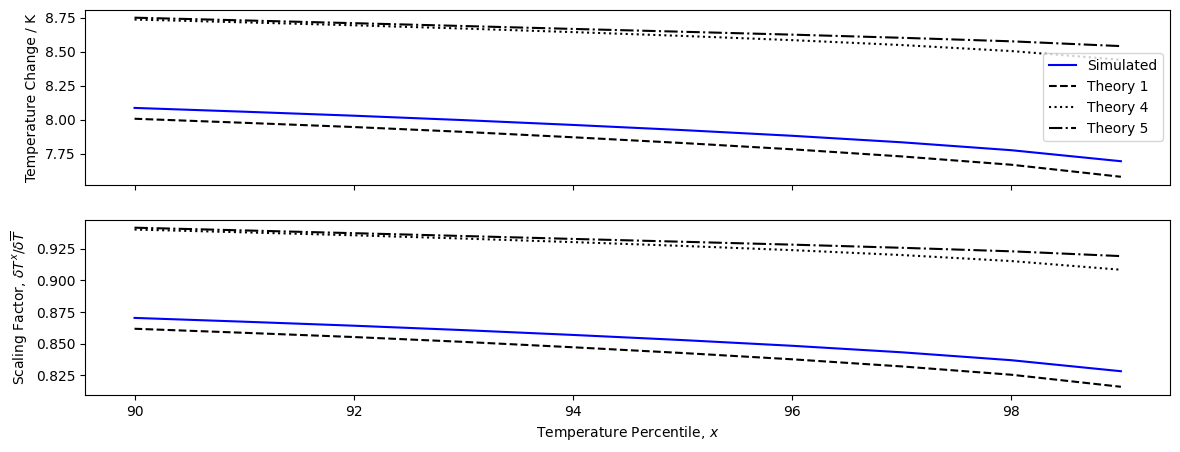

In [126]:
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant, color='blue', label='Simulated')
ax[0].plot(quantiles_all, temp_diff_theory, color='k', linestyle='--', label='Theory 1')
ax[0].plot(quantiles_all, temp_diff_theory4, color='k', linestyle=':', label='Theory 4')
ax[0].plot(quantiles_all, temp_diff_theory5, color='k', linestyle='-.', label='Theory 5')
ax[1].plot(quantiles_all, temp_diff_quant/(temp_summer_av[1] - temp_summer_av[0]), color='blue', label='Simulated')
ax[1].plot(quantiles_all, temp_diff_theory/(temp_summer_av[1] - temp_summer_av[0]), color='k', linestyle='--', label='Theory 1')
ax[1].plot(quantiles_all, temp_diff_theory4 / (temp_summer_av[1] - temp_summer_av[0]),
          color='k', linestyle=':', label='Theory 4')
ax[1].plot(quantiles_all, temp_diff_theory5 / (temp_summer_av[1] - temp_summer_av[0]),
          color='k', linestyle='-.', label='Theory 5')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();

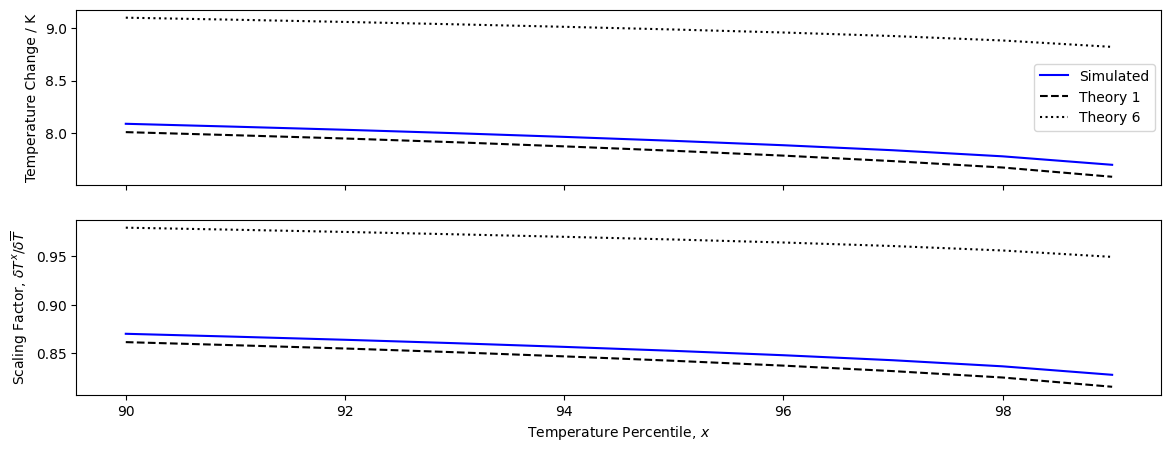

In [76]:
# Correction to theory 4 to get rid of the delta temp_ft term as this depends on delta temp_surface
# I think the neglect of Delta T^2 terms in this, may be an issue and why temperature does not decrease as much at high x.
lambda_quant = L_v * q_sat_ft_mean * alpha_ft_mean / (c_p + L_v * alpha_ft_quant * q_sat_ft_quant)
lambda_mean = L_v * q_sat_ft_mean * alpha_ft_mean / (c_p + L_v * alpha_ft_mean * q_sat_ft_mean)

denom6 = (1-lambda_quant) * denom4
gamma_t6 = ((c_p + L_v * alpha_mean * q_mean_mid) * (1+beta)) - lambda_mean * (c_p + L_v * alpha_mean * q_mean_mid)
gamma_t6 = gamma_t6 / denom6
gamma_r6 = (L_v * q_sat_mean * (1+beta) - lambda_mean * L_v * q_sat_mean) / denom6
gamma_r_quant6 = (-L_v * q_quant_mid + lambda_quant * L_v * q_sat_quant) / denom6
gamma_z_quant6 = (g - lambda_quant * g) / denom6
gamma_z6 = (-g * (1+beta) + lambda_mean * g) / denom6
temp_diff_theory6 = gamma_t6 * delta_t_mean + gamma_r6 * delta_rh_mean + gamma_r_quant6 * delta_rh_quant + \
                    gamma_z6 * delta_z_ft_mean + gamma_z_quant6 * delta_z_ft_mean

fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant, color='blue', label='Simulated')
ax[0].plot(quantiles_all, temp_diff_theory, color='k', linestyle='--', label='Theory 1')
ax[0].plot(quantiles_all, temp_diff_theory6, color='k', linestyle=':', label='Theory 6')
ax[1].plot(quantiles_all, temp_diff_quant/(temp_summer_av[1] - temp_summer_av[0]), color='blue', label='Simulated')
ax[1].plot(quantiles_all, temp_diff_theory/(temp_summer_av[1] - temp_summer_av[0]), color='k', linestyle='--', label='Theory')
ax[1].plot(quantiles_all, temp_diff_theory6 / (temp_summer_av[1] - temp_summer_av[0]),
          color='k', linestyle=':', label='Theory - fixed RHs')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();

## Theory for $\gamma^T$

From the above plots, it seems like the main contribution to the change in temperature on days exceeding percentile $x$ is due to the change in the mean temperature i.e. the $\gamma^T \delta \overline{T}$ contribution.

Here we assume constant relative humidity, $\delta r_x = \delta \overline{r} = 0$, in the definition of $\gamma^T$ as is simpler and did a good job at predicting $\delta T_x$.

If we next assume that the difference between the mean and $x$ day temperature ($\Delta T_x = T_x - \overline{T}$) and relative humidity ($\Delta r_x = r_x - \overline{r}$) are small, we can do a taylor expansion of $\gamma^T$.

The results of this are shown below as the theory value.

From this taylor expansion, we can say that for $\gamma^T > 1$ so the temperature of day $x$ increases more than the average day, we require:
$$
-\frac{\Delta r_x}{\Delta T_x} > (\overline{\alpha} - \frac{2}{\overline{T}}) \overline{r}
$$

where $\alpha = \frac{L_v}{R_v \bar{T}^2}$ is the Clausius-Clapeyron parameter.

The left hand side indicates the required drying per kelvin (denominator always positive) and the right hand side is always positive. So what this is saying is that the mean day must have larger relative humidity than the day $x$ day and the difference must exceed a threshold, $(\overline{\alpha} - \frac{2}{\overline{T}}) \overline{r}$, which depends on properties of the mean climate.

I.e. there is a threshold drying for the hottest day to increase faster than the mean. For this dataset, the threshold value is $0.037$ but the actual drying rate has a maximum value of $0.0065$ for $x=90$ and decreases to $0.0049$ for $x=99$. Hence we see that $\delta T_x$ decreases with $x$ because the drying rate decreases.


Threshold drying rate = 0.03709140266567403
Actual drying rate = 
[0.0065248  0.00643294 0.00632798 0.00620846 0.00608504 0.00593645
 0.0057648  0.00555854 0.00528829 0.00491308]


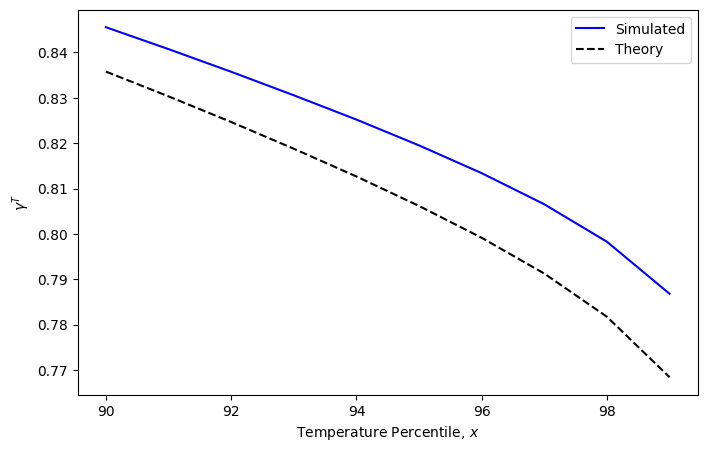

In [121]:
# Get theoretical value of gamma_t with zero RH changes, by doing a taylor expansion assuming
# difference of rh and temp of day x from mean day is small - the temp_surface_diff and rh_surface_diff terms are small

gamma_t_zero_rh_theory_prefactor = L_v * alpha_mean * q_sat_mean / (c_p + L_v * alpha_mean * q_mean_mid)
gamma_t_zero_rh_theory_temp_term = - gamma_t_zero_rh_theory_prefactor * (alpha_mean - 2 / temp_mean_mid) * rh_mean[0] * temp_surface_diff[0]
gamma_t_zero_rh_theory_rh_term = - gamma_t_zero_rh_theory_prefactor * rh_surface_diff[0]
gamma_t_zero_rh_theory = 1 + gamma_t_zero_rh_theory_temp_term + gamma_t_zero_rh_theory_rh_term

fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True)
ax.plot(quantiles_all, gamma_t_zero_rh, color='blue', label='Simulated')
ax.plot(quantiles_all, gamma_t_zero_rh_theory, color='k', linestyle='--', label='Theory')
ax.set_xlabel('Temperature Percentile, $x$')
ax.set_ylabel('$\gamma^T$')
ax.legend()
print(f'Threshold drying rate = {(alpha_mean - 2 / temp_mean_mid) * rh_mean[0]}')
print(f'Actual drying rate = \n{-rh_surface_diff[0]/temp_surface_diff[0]}')

### Breakdown of $\gamma^T$ contributions
The absolute value of $\gamma^T$ is larger for the tropics compared to the extratropics because the $\Delta T_x$ term is smaller (varies from 0.9K to 2K in tropics compared to 5.8K to 7.8K in the extratropics).

The relative humidity and temperature contributions are shown explicitly below.

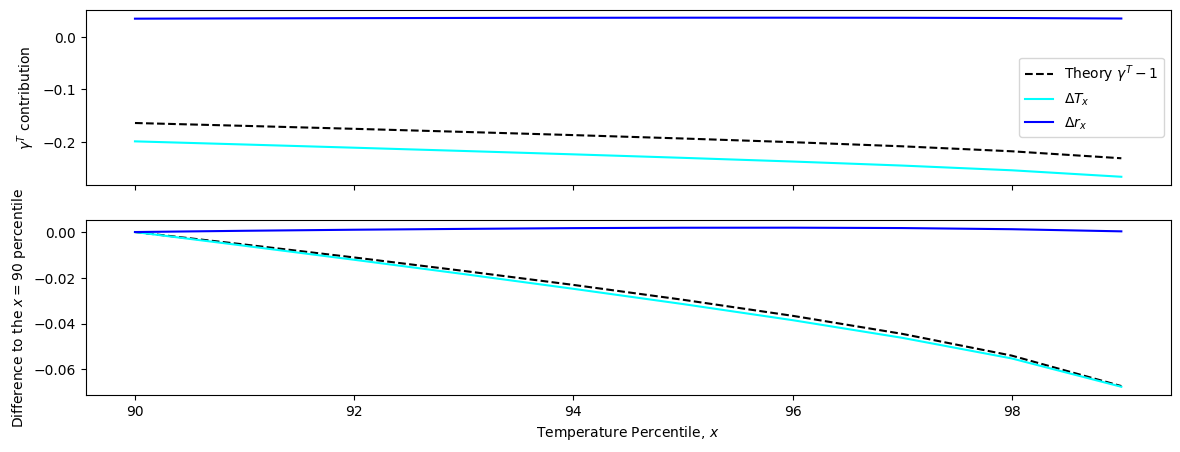

In [300]:
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, gamma_t_zero_rh_theory - 1, color='k', label='Theory $\gamma^T - 1$', linestyle='--')
ax[0].plot(quantiles_all, gamma_t_zero_rh_theory_temp_term, color='cyan', label='$\Delta T_x$')
ax[0].plot(quantiles_all, gamma_t_zero_rh_theory_rh_term, color='blue', label='$\Delta r_x$')
ax[1].plot(quantiles_all, gamma_t_zero_rh_theory - gamma_t_zero_rh_theory[0], color='k', label='Theory $\gamma^T - 1$', linestyle='--')
ax[1].plot(quantiles_all, gamma_t_zero_rh_theory_temp_term - gamma_t_zero_rh_theory_temp_term[0],
           color='cyan', label='$\Delta T_x$')
ax[1].plot(quantiles_all, gamma_t_zero_rh_theory_rh_term - gamma_t_zero_rh_theory_rh_term[0],
           color='blue', label='$\Delta r_x$')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('$\gamma^T$ contribution')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile')
ax[0].legend();

## Taylor expansion of $q_x = q(\overline{T}+\Delta T_x, \overline{r} + \Delta r_x)$
The plot below shows that it is important to keep the $\Delta T_x^2$ term in this expansion.

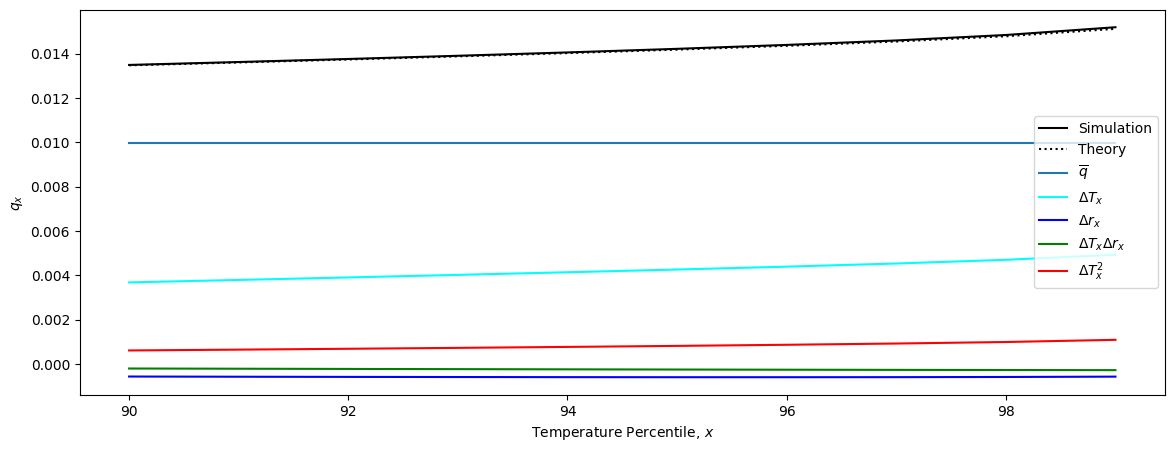

In [302]:
# Decomposition of taylor expansion of q_x in current climate to see if it gives close approximation
q_term_t1 = alpha_mean * q_mean_mid * temp_surface_diff[0]
q_term_r1 = q_sat_mean * rh_surface_diff[0]
q_term_tr = alpha_mean * q_sat_mean * temp_surface_diff[0] * rh_surface_diff[0]
q_term_t2 = 0.5 * alpha_mean * q_mean_mid * (alpha_mean * temp_mean_mid - 2) / temp_mean_mid * temp_surface_diff[0]**2

fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(quantiles_all, q_quant[0], label='Simulation', color='k')
ax.plot(quantiles_all, q_mean_mid + q_term_t1 + q_term_r1 + q_term_tr + q_term_t2, label='Theory', color='k', linestyle=':')
ax.plot(quantiles_all, q_mean_mid * np.ones(n_quantiles), label='$\overline{q}$')
ax.plot(quantiles_all, q_term_t1, label='$\Delta T_x$', color='cyan')
ax.plot(quantiles_all, q_term_r1, label='$\Delta r_x$', color='blue')
ax.plot(quantiles_all, q_term_tr, label='$\Delta T_x \Delta r_x$', color='green')
ax.plot(quantiles_all, q_term_t2, label='$\Delta T_x^2$', color='red')
ax.set_ylabel('$q_x$')
ax.set_xlabel('Temperature Percentile, $x$')
ax.legend();

Now change the climate ($\delta$) and take the taylor series of both $\delta q_x$ and $\delta q(\overline{T}+\Delta T_x, \overline{r} + \Delta r_x)$

Significant terms: [ 0  3  4  5 14 15]


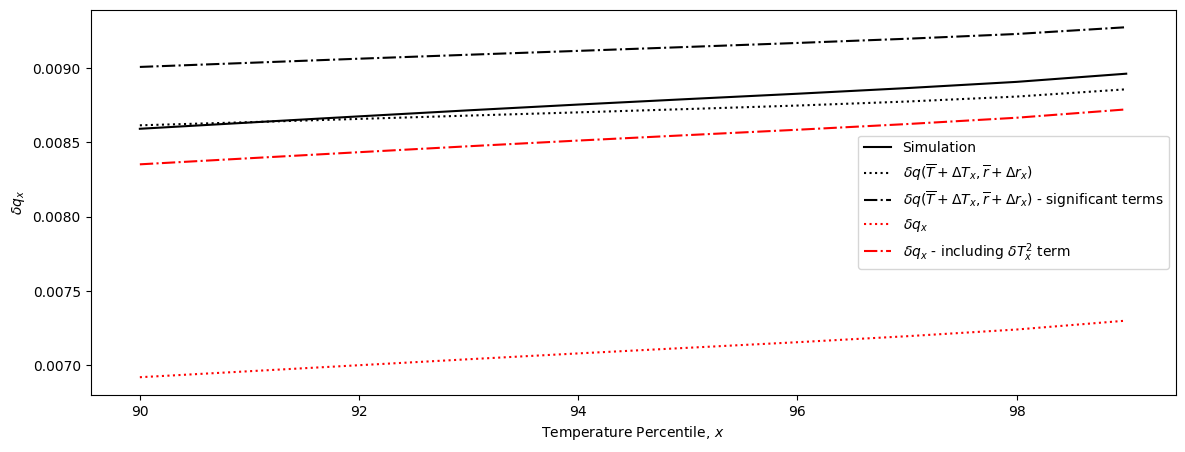

In [433]:
# Now change climate and do new taylor expansion for difference between climates
terms = []
terms += [alpha_mean * q_mean_mid * delta_t_mean]
terms += [q_sat_mean * delta_rh_mean]
terms += [alpha_mean * q_sat_mean * delta_t_mean * delta_rh_mean]
terms += [alpha_mean * q_mean_mid * temp_diff_quant]
terms += [alpha_mean * q_mean_mid * (alpha_mean * temp_quant_mid - 2 * temp_quant_mid / temp_mean_mid -
                                     alpha_mean * temp_mean_mid + 1) * delta_t_mean]
terms += [alpha_mean * q_mean_mid * (alpha_mean - 2/temp_mean_mid) * temp_diff_quant * delta_t_mean]
terms += [alpha_mean * q_sat_mean * temp_surface_diff[0] * delta_rh_mean]
terms += [alpha_mean * q_sat_mean * rh_surface_diff[0] * delta_t_mean]
terms += [q_sat_mean * (delta_rh_quant - delta_rh_mean)]
terms += [alpha_mean * q_sat_mean * rh_surface_diff[0] * temp_diff_quant]
terms += [alpha_mean * q_sat_mean * temp_surface_diff[0] * (delta_rh_quant - delta_rh_mean)]
terms += [alpha_mean * q_sat_mean * rh_surface_diff[0] * (alpha_mean * temp_quant_mid - 2 * temp_quant_mid / temp_mean_mid -
                                                          alpha_mean * temp_mean_mid + 1) * delta_t_mean]
terms += [alpha_mean * q_sat_mean * rh_surface_diff[0] * (alpha_mean - 2/temp_mean_mid) * temp_diff_quant * delta_t_mean]
terms += [0.5 * alpha_mean * q_sat_mean / temp_mean_mid * (alpha_mean * temp_mean_mid - 2) * temp_surface_diff[0]**2 * delta_rh_mean]
terms += [alpha_mean * q_mean_mid * (alpha_mean * temp_mean_mid - 2) * temp_surface_diff[0] / temp_mean_mid * temp_diff_quant]
terms += [alpha_mean * q_mean_mid * temp_surface_diff[0] / temp_mean_mid * (
        temp_quant_mid * (alpha_mean**2 * temp_mean_mid - 2.5 * alpha_mean + 3 / temp_mean_mid) +
        temp_mean_mid * (-alpha_mean**2 * temp_mean_mid + alpha_mean) - 1) * delta_t_mean]
delta_q_theory = sum(terms)

# What does theory look like if only keep terms which contribute more than 5%
q_theory_percent = np.asarray([np.abs(term).max()*100/delta_q_theory.max() for term in terms])
signif_thresh = 5
use_term = q_theory_percent > signif_thresh
terms_signif = [terms[i] for i in range(len(terms)) if use_term[i]]
delta_q_theory_signif = sum(terms_signif)

delta_q_theory2 = alpha_quant * q_quant_mid * temp_diff_quant + q_sat_quant * delta_rh_quant + \
                  alpha_quant * q_sat_quant * temp_diff_quant * delta_rh_quant
delta_q_theory2_squared = delta_q_theory2 + 0.5 * alpha_quant * q_quant_mid / temp_quant_mid * (alpha_quant * temp_quant_mid - 2) * temp_diff_quant**2

fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(quantiles_all, q_quant[1] - q_quant[0], label='Simulation', color='k')
ax.plot(quantiles_all, delta_q_theory,
        label='$\delta q(\overline{T}+\Delta T_x, \overline{r} + \Delta r_x)$', color='k', linestyle=':')
ax.plot(quantiles_all, delta_q_theory_signif,
        label='$\delta q(\overline{T}+\Delta T_x, \overline{r} + \Delta r_x)$ - significant terms', color='k', linestyle='-.')
ax.plot(quantiles_all, delta_q_theory2, label='$\delta q_x$', color='r', linestyle=':')
ax.plot(quantiles_all, delta_q_theory2_squared, label='$\delta q_x$ - including $\delta T_x^2$ term', color='r', linestyle='-.')
ax.set_ylabel('$\delta q_x$')
ax.set_xlabel('Temperature Percentile, $x$')
ax.legend()
print(f'Significant terms: {np.where(use_term)[0]}')

The black dotted line value of $\delta q_x$ produced by the above theory is under-estimated for large $x$ because we have ignored the important $\delta T_x^2$ and $\delta \overline{T}^2$ terms in the taylor expansion, overall though the theory is pretty good.

## Translating $q_x$ expansion into a theory for $T_x$
In a changing climate, we have $\delta q_x(T_x, r_x) = \delta q(\overline{T}+\Delta T_x, \overline{r} + \Delta r_x)$ i.e. we can equate the dotted black and red lines in the above plot and rearrange so all $\delta T_x$ terms are on one side.

We can thus taylor expand both sides to give an equation for $\delta T_x$ (the right hand side will be first taylor expanded in $\Delta$
terms and then in $\delta$ terms). The theory gives a massive underestimate though.

In [437]:
denom5 = alpha_quant * q_quant_mid - (terms[3] + terms[5] + terms[14])/temp_diff_quant
gamma_t5 = (terms[0] + terms[4] + terms[15])/delta_t_mean
temp_diff_theory5 = gamma_t5 / denom5 * delta_t_mean
print(temp_diff_theory5)
print(temp_diff_theory)

[1.10903808 1.08275843 1.05272147 1.01851822 0.9792559  0.93467291
 0.88297211 0.82056069 0.73978896 0.6127897 ]
[8.00704049 7.97730504 7.94616549 7.91065194 7.87096272 7.82870846
 7.78253792 7.73008704 7.6690529  7.58056426]
